# Boat Object Detection with YOLO

In this exercise, you will fine-tune a YOLO model for boat detection in satellite imagery.

In [34]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import requests
import pandas as pd
import os
import cv2
import random
import shutil

## Data Collection

Download the training and test datasets.

In [19]:
# URLs for the dataset files
data_train_features_url = 'https://www.raphaelcousin.com/modules/data-science-practice/module7/exercise/X_train.pkl'
data_train_labels_url = 'https://www.raphaelcousin.com/modules/data-science-practice/module7/exercise/y_train.pkl'
data_test_features_url = 'https://www.raphaelcousin.com/modules/data-science-practice/module7/exercise/X_test.pkl'

def download_file(url, file_name):
    if os.path.exists(file_name):
        print(f"Already downloaded {file_name}")
    else:
        response = requests.get(url)
        response.raise_for_status()
        with open(file_name, 'wb') as file:
            file.write(response.content)
        print(f'Downloaded {file_name}')

data_root = os.getcwd()
X_train_file_name = "X_train.pkl"
y_train_file_name = "y_train.pkl"
X_test_file_name = "X_test.pkl"

# Download the files
download_file(data_train_features_url, os.path.join(data_root, X_train_file_name))
download_file(data_train_labels_url, os.path.join(data_root, y_train_file_name))
download_file(data_test_features_url, os.path.join(data_root, X_test_file_name))

Already downloaded /home/pierre/ms2a/racousin/data_science_practice_2025/21404828/module7/X_train.pkl
Already downloaded /home/pierre/ms2a/racousin/data_science_practice_2025/21404828/module7/y_train.pkl
Already downloaded /home/pierre/ms2a/racousin/data_science_practice_2025/21404828/module7/X_test.pkl


In [37]:
# Load the training data
with open('X_train.pkl', 'rb') as f:
    X = pickle.load(f)
    train_images = X

with open('y_train.pkl', 'rb') as f:
    y = pickle.load(f)
    train_labels = y

with open(X_test_file_name, "rb") as f:
    test_images = pickle.load(f)

print(f"Loaded {len(X)} training images")
print(f"Sample image shape: {X[0].shape}")
print(f"Sample labels shape: {y[0].shape}")
print(f"Sample labels (YOLO format - class_id, x_center, y_center, width, height):\n{y[0]}")

Loaded 496 training images
Sample image shape: (418, 466, 3)
Sample labels shape: (1, 5)
Sample labels (YOLO format - class_id, x_center, y_center, width, height):
[[0.       0.659871 0.57177  0.109442 0.162679]]


## Data Visualization

Display sample images with bounding boxes.

In [7]:
def plot_image_with_boxes(image, boxes, ax=None):
    """
    Plot an image with bounding boxes
    boxes: numpy array with shape (n, 5) - [class_id, x_center, y_center, width, height]
    All box coordinates are normalized (0-1)
    """
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    
    ax.imshow(image)
    height, width = image.shape[:2]
    
    # Draw each bounding box
    for box in boxes:
        class_id, x_center, y_center, box_width, box_height = box
        
        # Convert from normalized YOLO format to pixel coordinates
        x_center_px = x_center * width
        y_center_px = y_center * height
        box_width_px = box_width * width
        box_height_px = box_height * height
        
        # Calculate top-left corner
        x1 = x_center_px - box_width_px / 2
        y1 = y_center_px - box_height_px / 2
        
        # Draw rectangle
        rect = patches.Rectangle(
            (x1, y1), box_width_px, box_height_px,
            linewidth=2, edgecolor='red', facecolor='none'
        )
        ax.add_patch(rect)
        
        # Add label
        ax.text(x1, y1-5, 'boat', color='red', fontsize=10, 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    
    ax.axis('off')
    return ax

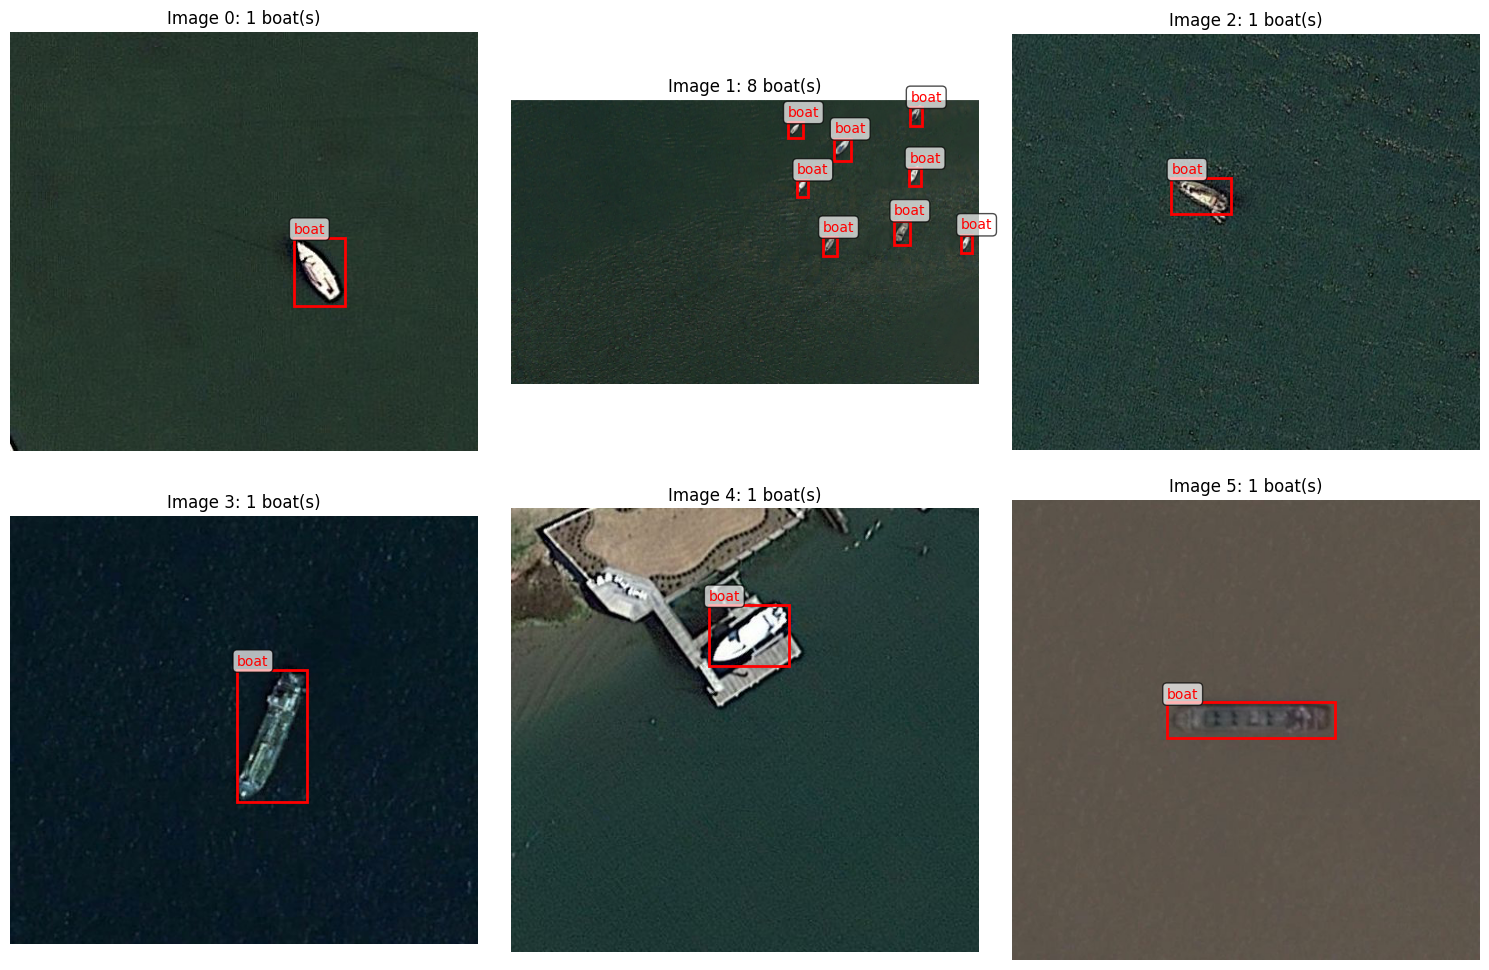

In [69]:
# Display 5 sample images with bounding boxes
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i in range(6):
    plot_image_with_boxes(X[i], y[i], ax=axes[i])
    axes[i].set_title(f'Image {i}: {len(y[i])} boat(s)')

plt.tight_layout()
plt.show()

Yolo classification result visualization

In [17]:
def plot_yolo_results(results, image_files):
    fig, axes = plt.subplots(len(results), figsize=(16, 6*len(results)))
    if len(results) == 1:
        axes = np.array([axes])
        
    for idx, (result, path) in enumerate(zip(results, image_files)):
        result_img = result.plot()  # YOLOv8 draws boxes automatically
        axes[idx].imshow(result_img)
        axes[idx].set_title(f'Detected: {len(result.boxes)} objects', fontsize=14)
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

## Model Setup

Load a pre-trained YOLO model and test it on the training images.

In [65]:
from ultralytics import YOLO

# Load a pre-trained YOLOv8 model (nano version)
model = YOLO('yolo11s.pt')

print("Model loaded successfully!")

Model loaded successfully!


In [66]:
# Test the pre-trained model on a sample image
# Save a sample image temporarily
from PIL import Image
sample_img = Image.fromarray(X[0])
sample_file = 'temp_sample.png'
sample_img.save(sample_file)

# Run prediction
sample_results = model.predict(source=sample_file, conf=0.25)

print(f"Pre-trained model detected {len(sample_results[0].boxes)} objects")
print("Note: The pre-trained model may not detect boats well - you need to fine-tune it!")


image 1/1 /home/pierre/ms2a/racousin/data_science_practice_2025/21404828/module7/temp_sample.png: 576x640 (no detections), 202.6ms
Speed: 2.8ms preprocess, 202.6ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)
Pre-trained model detected 0 objects
Note: The pre-trained model may not detect boats well - you need to fine-tune it!


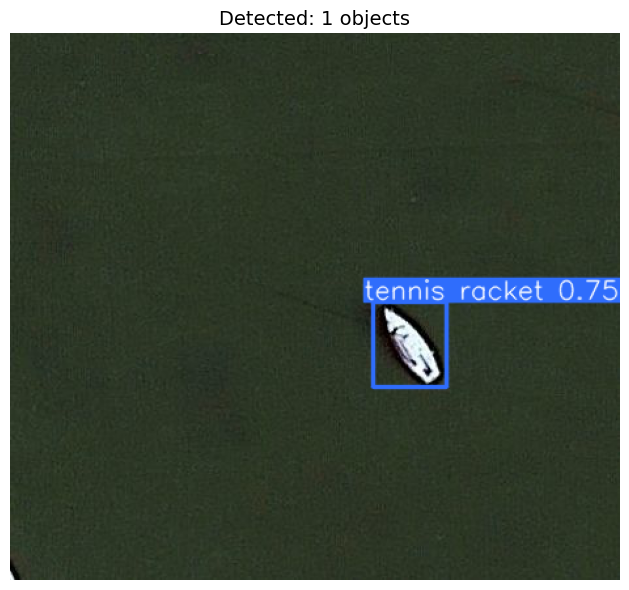

In [18]:
plot_yolo_results(sample_results, [sample_file])

## Fine-tune your YOLO model

Your task is to fine-tune the YOLO model on the boat detection dataset to achieve a mAP50 score of at least 0.73 on the test set.

Data augmentation

In [72]:
from typing import Tuple, List

def horizontal_flip(image: np.ndarray, labels: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Flip image horizontally and update bounding boxes."""
    aug_image = np.fliplr(image)
    aug_labels = labels.copy()
    aug_labels[:, 1] = 1.0 - aug_labels[:, 1]
    return aug_image, aug_labels


def random_rotation(image: np.ndarray, labels: np.ndarray, 
                    max_angle: float = 15) -> Tuple[np.ndarray, np.ndarray]:
    """Rotate image by random angle and update bounding boxes."""
    h, w = image.shape[:2]
    angle = np.random.uniform(-max_angle, max_angle)
    
    # Rotation matrix
    center = (w / 2, h / 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    aug_image = cv2.warpAffine(image, M, (w, h), 
                               borderMode=cv2.BORDER_REFLECT)
    
    # Convert YOLO to corner format for rotation
    aug_labels = labels.copy()
    corners = yolo_to_corners(aug_labels, w, h)
    
    # Rotate all 4 corners of each box
    rotated_corners = []
    for box_corners in corners:
        pts = np.array([[box_corners[0], box_corners[1]],
                       [box_corners[2], box_corners[1]],
                       [box_corners[2], box_corners[3]],
                       [box_corners[0], box_corners[3]]])
        ones = np.ones((4, 1))
        pts_homo = np.hstack([pts, ones])
        rotated_pts = M.dot(pts_homo.T).T
        
        # Get new bounding box from rotated corners
        x_min, y_min = rotated_pts.min(axis=0)
        x_max, y_max = rotated_pts.max(axis=0)
        rotated_corners.append([x_min, y_min, x_max, y_max])
    
    # Convert back to YOLO format
    aug_labels = corners_to_yolo(np.array(rotated_corners), w, h, aug_labels[:, 0])
    return aug_image, aug_labels


def random_scale(image: np.ndarray, labels: np.ndarray, 
                 scale_range: Tuple[float, float] = (0.8, 1.2)) -> Tuple[np.ndarray, np.ndarray]:
    """Scale image and bounding boxes."""
    h, w = image.shape[:2]
    scale = np.random.uniform(*scale_range)
    
    new_h, new_w = int(h * scale), int(w * scale)
    aug_image = cv2.resize(image, (new_w, new_h))
    
    # Crop or pad to original size
    if scale > 1.0:  # Crop center
        y_start = (new_h - h) // 2
        x_start = (new_w - w) // 2
        aug_image = aug_image[y_start:y_start+h, x_start:x_start+w]
        
        # Adjust bounding boxes for crop
        aug_labels = labels.copy()
        aug_labels[:, 1] = (aug_labels[:, 1] * new_w - x_start) / w
        aug_labels[:, 2] = (aug_labels[:, 2] * new_h - y_start) / h
        aug_labels[:, 3] = aug_labels[:, 3] * scale
        aug_labels[:, 4] = aug_labels[:, 4] * scale
    else:  # Pad
        pad_h = (h - new_h) // 2
        pad_w = (w - new_w) // 2
        aug_image = cv2.copyMakeBorder(aug_image, pad_h, h-new_h-pad_h, 
                                       pad_w, w-new_w-pad_w, 
                                       cv2.BORDER_REFLECT)
        
        # Adjust bounding boxes for padding
        aug_labels = labels.copy()
        aug_labels[:, 1] = (aug_labels[:, 1] * w * scale + pad_w) / w
        aug_labels[:, 2] = (aug_labels[:, 2] * h * scale + pad_h) / h
        aug_labels[:, 3] = aug_labels[:, 3] * scale
        aug_labels[:, 4] = aug_labels[:, 4] * scale
    
    # Clip boxes to valid range
    aug_labels = clip_boxes(aug_labels)
    return aug_image, aug_labels


def brightness_contrast(image: np.ndarray, labels: np.ndarray,
                        brightness_range: Tuple[float, float] = (-30, 30),
                        contrast_range: Tuple[float, float] = (0.8, 1.2)) -> Tuple[np.ndarray, np.ndarray]:
    """Adjust brightness and contrast."""
    brightness = np.random.uniform(*brightness_range)
    contrast = np.random.uniform(*contrast_range)
    
    aug_image = image.astype(np.float32)
    aug_image = aug_image * contrast + brightness
    aug_image = np.clip(aug_image, 0, 255).astype(np.uint8)
    
    return aug_image, labels.copy()


def gaussian_noise(image: np.ndarray, labels: np.ndarray,
                   noise_std: float = 10) -> Tuple[np.ndarray, np.ndarray]:
    """Add Gaussian noise to image."""
    noise = np.random.normal(0, noise_std, image.shape)
    aug_image = image.astype(np.float32) + noise
    aug_image = np.clip(aug_image, 0, 255).astype(np.uint8)
    
    return aug_image, labels.copy()


# Helper functions
def yolo_to_corners(labels: np.ndarray, w: int, h: int) -> np.ndarray:
    """Convert YOLO format to corner format (x_min, y_min, x_max, y_max)."""
    corners = np.zeros((len(labels), 4))
    corners[:, 0] = (labels[:, 1] - labels[:, 3] / 2) * w  # x_min
    corners[:, 1] = (labels[:, 2] - labels[:, 4] / 2) * h  # y_min
    corners[:, 2] = (labels[:, 1] + labels[:, 3] / 2) * w  # x_max
    corners[:, 3] = (labels[:, 2] + labels[:, 4] / 2) * h  # y_max
    return corners


def corners_to_yolo(corners: np.ndarray, w: int, h: int, 
                    class_ids: np.ndarray) -> np.ndarray:
    """Convert corner format to YOLO format."""
    yolo = np.zeros((len(corners), 5))
    yolo[:, 0] = class_ids
    yolo[:, 1] = ((corners[:, 0] + corners[:, 2]) / 2) / w  # x_center
    yolo[:, 2] = ((corners[:, 1] + corners[:, 3]) / 2) / h  # y_center
    yolo[:, 3] = (corners[:, 2] - corners[:, 0]) / w        # width
    yolo[:, 4] = (corners[:, 3] - corners[:, 1]) / h        # height
    return yolo


def clip_boxes(labels: np.ndarray) -> np.ndarray:
    """Clip bounding boxes to valid range [0, 1]."""
    labels[:, 1:5] = np.clip(labels[:, 1:5], 0, 1)
    return labels


def augment_sample(image: np.ndarray, labels: np.ndarray, 
                   n_augmentations: int = 3) -> List[Tuple[np.ndarray, np.ndarray]]:
    """Generate multiple augmented versions of a single image."""
    augmentations = [
        horizontal_flip,
        random_rotation,
        random_scale,
        brightness_contrast,
        gaussian_noise
    ]
    
    results = []
    selected_augs = np.random.choice(len(augmentations), 
                                     size=min(n_augmentations, len(augmentations)), 
                                     replace=False)
    
    for idx in selected_augs:
        aug_img, aug_labels = augmentations[idx](image, labels)
        results.append((aug_img, aug_labels))
    
    return results

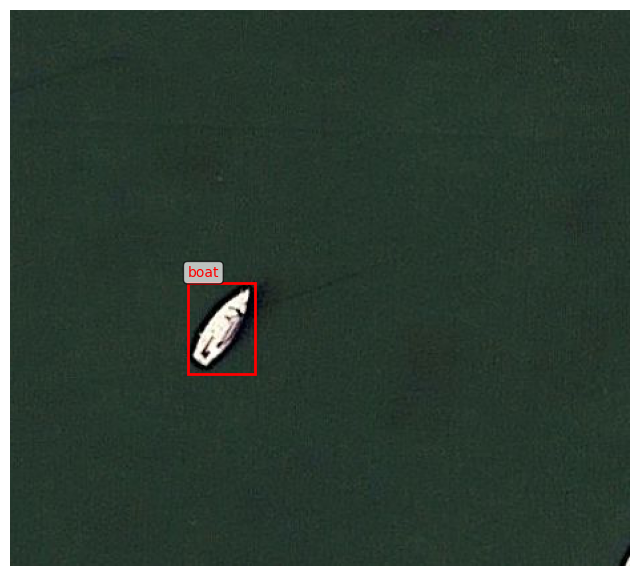

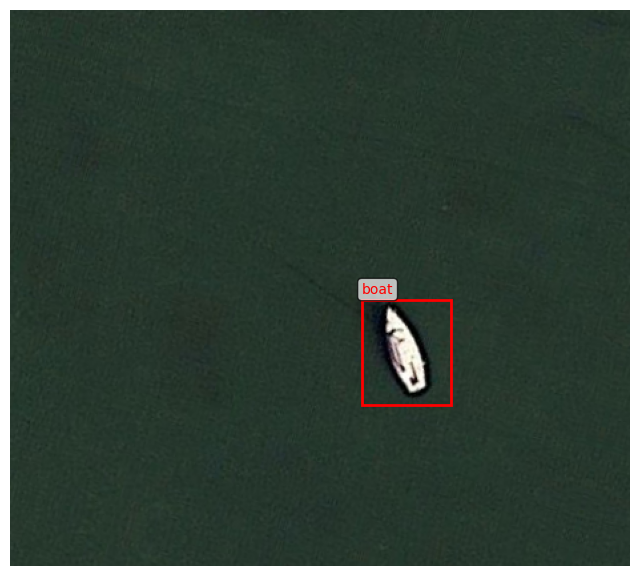

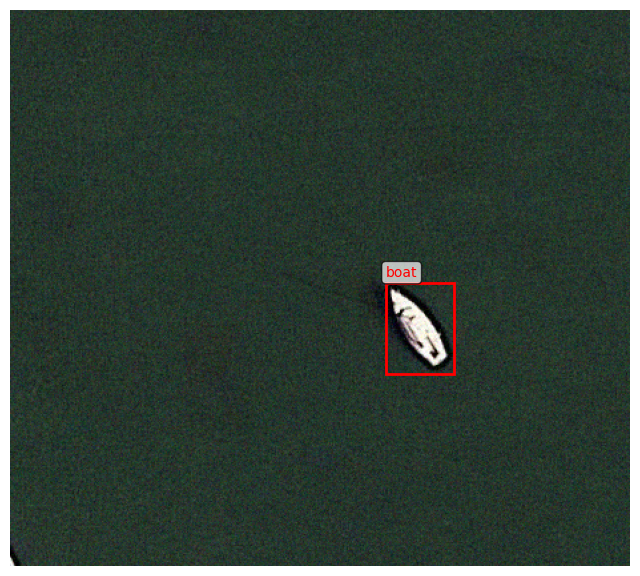

In [74]:
sample_train_image = train_images[0]
sample_train_labels = train_labels[0]

# plot_image_with_boxes(sample_train_image, sample_train_labels)

sample_train_augmentations = augment_sample(sample_train_image, sample_train_labels)

for sample_train_image_augmentation, sample_train_label_augmentation in sample_train_augmentations:
    plot_image_with_boxes(sample_train_image_augmentation, sample_train_label_augmentation)

Preparing the dataset

In [ ]:
import uuid

def save_sample(image, labels, split = "train"):
    os.makedirs(os.path.join("data", split, "images"), exist_ok=True)
    os.makedirs(os.path.join("data", split, "labels"), exist_ok=True)
    
    id = uuid.uuid4().hex

    Image.fromarray(image).save(os.path.join("data", split, "images", f"{id}.png"))
    label_str = "\n".join([
        f"{int(label[0])} {label[1]} {label[2]} {label[3]} {label[4]}"
        for label in labels
    ])
    with open(os.path.join("data", split, "labels", f"{id}.txt"), "w") as f:
        f.write(label_str)

def prepare_data(train_images, train_labels):
    shutil.rmtree("data", ignore_errors=True)
    
    val_mask = np.random.randint(5, size=len(train_images)) == 0

    if isinstance(train_images, np.ndarray):
        val_images = train_images[val_mask]
        train_images = train_images[~val_mask]
    else:
        val_images = [image for is_val, image in zip(val_mask, train_images) if is_val]
        train_images = [image for is_val, image in zip(val_mask, train_images) if not is_val]

    if isinstance(train_labels, np.ndarray):
        val_labels = train_labels[val_mask]
        train_labels = train_labels[~val_mask]
    else:
        val_labels = [label for is_val, label in zip(val_mask, train_labels) if is_val]
        train_labels = [label for is_val, label in zip(val_mask, train_labels) if not is_val]

    for image, labels in zip(train_images, train_labels):
        save_sample(image, labels, "train")
        for image_alt, labels_alt in augment_sample(image, labels):
            save_sample(image_alt, labels_alt, split="train")

    for image, labels in zip(val_images, val_labels):
        save_sample(image, labels, "val")
        for image_alt, labels_alt in augment_sample(image, labels):
            save_sample(image_alt, labels_alt, split="val")


In [56]:
prepare_data(train_images, train_labels)

Creating the YOLO configuration file

In [29]:
# Create dataset config file
config = f"""
path: {os.path.join(os.getcwd(), "data")}
train: train/images
val: val/images

nc: 1
names: ["boats"]
"""

with open('boats.yaml', 'w') as f:
    f.write(config)

print('Config file created!')

Config file created!


In [ ]:
# Fine-tune YOLOv8
model = YOLO('yolo11s.pt')  # Start from pre-trained weights

# Train
results = model.train(
    data='boats.yaml',
    epochs=30,
    imgsz=640,
    batch=24, # Larger batch since we augmented our data
    name='boat_detector',
    patience=5,  # Early stopping
    save=True,
    verbose=True,
    device="cuda"
)


In [58]:
# Load best model
model = YOLO(os.path.join('runs/detect/boat_detector/weights/best.pt'))

# Evaluate on validation set
metrics = model.val(data='boats.yaml')

print('\nValidation Metrics:')
print(f'  mAP50: {metrics.box.map50:.3f}')
print(f'  mAP50-95: {metrics.box.map:.3f}')
print(f'  Precision: {metrics.box.mp:.3f}')
print(f'  Recall: {metrics.box.mr:.3f}')

Ultralytics 8.3.217 🚀 Python-3.11.13 torch-2.9.0+cu128 CPU (Intel Core i7-10850H 2.70GHz)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3331.2±807.5 MB/s, size: 247.7 KB)
val: Scanning /home/pierre/ms2a/racousin/data_science_practice_2025/21404828/module7/data/val/labels.cache... 44 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 44/44 69.9Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 0.7it/s 4.1s2.9s
                   all         44        115        0.9      0.826      0.871      0.485
Speed: 1.3ms preprocess, 75.8ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to /home/pierre/ms2a/racousin/data_science_practice_2025/runs/detect/val

Validation Metrics:
  mAP50: 0.871
  mAP50-95: 0.485
  Precision: 0.900
  Recall: 0.826


## Generate Predictions for Test Set

Generate predictions on the test set and save them in the required CSV format.

In [59]:
# Load test data
with open('X_test.pkl', 'rb') as f:
    X_test = pickle.load(f)

print(f"Loaded {len(X_test)} test images")

Loaded 125 test images


In [60]:
# Generate predictions on test set
# Your trained model should be used here
# Format: CSV with columns: image_id, box_idx, class_id, confidence, x_center, y_center, width, height

predictions = []

for img_idx, img in enumerate(X_test):
    # Save image temporarily
    temp_img = Image.fromarray(img)
    temp_img.save('temp_test.png')
    
    # Run prediction with your fine-tuned model
    # Replace 'model' with your fine-tuned model
    results = model.predict(source='temp_test.png', conf=0.25, verbose=False)
    
    # Extract predictions
    for box_idx, box in enumerate(results[0].boxes):
        # Get box data in YOLO format (normalized coordinates)
        x_center, y_center, width, height = box.xywhn[0].cpu().numpy()
        confidence = box.conf[0].cpu().numpy()
        class_id = int(box.cls[0].cpu().numpy())
        
        predictions.append({
            'image_id': img_idx,
            'box_idx': box_idx,
            'class_id': 0,  # Always 0 for boat
            'confidence': float(confidence),
            'x_center': float(x_center),
            'y_center': float(y_center),
            'width': float(width),
            'height': float(height)
        })
    
    if (img_idx + 1) % 10 == 0:
        print(f"Processed {img_idx + 1}/{len(X_test)} images")

print(f"\nTotal predictions: {len(predictions)}")

Processed 10/125 images
Processed 20/125 images
Processed 30/125 images
Processed 40/125 images
Processed 50/125 images
Processed 60/125 images
Processed 70/125 images
Processed 80/125 images
Processed 90/125 images
Processed 100/125 images
Processed 110/125 images
Processed 120/125 images

Total predictions: 394


In [61]:
# Save predictions to CSV
df_predictions = pd.DataFrame(predictions)
df_predictions.to_csv('predictions.csv', index=False)

print("Predictions saved to predictions.csv")
print("\nFirst few predictions:")
print(df_predictions.head(10))

Predictions saved to predictions.csv

First few predictions:
   image_id  box_idx  class_id  confidence  x_center  y_center     width  \
0         0        0         0    0.931039  0.566957  0.433911  0.163185   
1         2        0         0    0.944958  0.478512  0.419848  0.311017   
2         3        0         0    0.939981  0.360782  0.360920  0.242632   
3         4        0         0    0.941911  0.465892  0.409978  0.124385   
4         5        0         0    0.885199  0.433983  0.456381  0.358108   
5         6        0         0    0.933216  0.577095  0.557731  0.460858   
6         7        0         0    0.774618  0.457104  0.336769  0.574533   
7         8        0         0    0.879096  0.591859  0.479276  0.166026   
8         9        0         0    0.917565  0.556046  0.533917  0.206747   
9        10        0         0    0.959019  0.368328  0.414888  0.442727   

     height  
0  0.126748  
1  0.225852  
2  0.124558  
3  0.445652  
4  0.509711  
5  0.508770  
6  0